In [1]:
%run pylib/ml_fit dr3 show dark
import warnings
warnings.filterwarnings("ignore")
self, dfc = kde_setup('d log_epeak diffuse'.split())



# KDE approach  (DR3)

<h5 style="text-align:right; margin-right:15px"> 2024-01-06 15:31</h5>

Not applying ML, so no fit to targets to generate prediction model. Instead we compute KDE probability density distributions
for the ML targets, which we then apply to the unid and bcu associations.

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fe0e8a3f340>

### Data selection cut: "0.15<Ep<4 & d>0.2 & variability<25"

subset,blazar,psr,msp,unid,bcu
counts,,,,,
all,2127,143,147,2179,1554
selected,168,135,144,1366,354
%,8,94,98,63,23


## Create KDE functions  in lieu of ML training
* Features: ['d', 'log_epeak', 'diffuse'] 
* Targets: dict_keys(['psr', 'msp', 'blazar'])

In [38]:
def hist_kde(self,df, axx):
    """Histograms of the blazar KDE values...
    """
    data = df.copy()
    def hist_blazar_kde( ax):
        data['blazar class']= data.association
        sns.histplot(data, ax=ax, x='blazar_kde', hue='blazar class',
                     hue_order='bll fsrq bcu'.split(), palette=self.palette,
                     element='step')
        ax.set(xticks=np.arange(0,1.51, 0.5), xlabel='blazar KDE')
     
    def hist_pulsar_kde( ax):
        data['pulsar class']= data.association
        sns.histplot(data, ax=ax, x='blazar_kde', hue='pulsar class',
                     hue_order='psr msp'.split(), palette=self.palette,
                     element='step')
        ax.set(xticks=np.arange(0,1.51, 0.5), xlabel='blazar KDE')

    hist_blazar_kde( ax=axx[0])
    hist_pulsar_kde( ax=axx[1])
    return fig

### Blazar KDE for blazar and pulsar types
The KDE for blazars is determined from the `bll` and `fsrq` classes. Here we 
examine distributions
of it for the blazar types, including also `bcu`, and the pulsar types.

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fe0c9c79240>
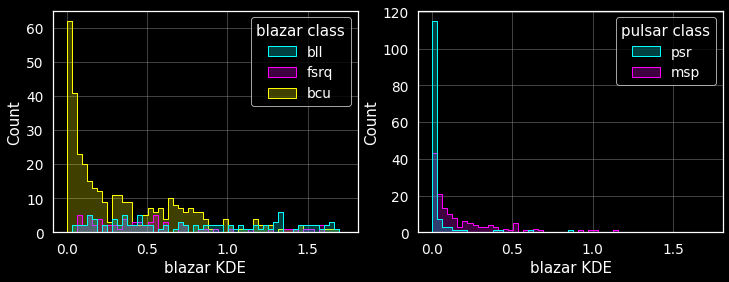

Note that the `bcu` has a component that does not correspond to that
expected for the known blazar types. The pulsars show show small 
values of the blazar KDE, but there is a little mixing with for `msp`. 

In [40]:
fig, axx = plt.subplots(ncols=2, figsize=(12,4))   
show(f"""### Blazar KDE for blazar and pulsar types
The KDE for blazars is determined from the `bll` and `fsrq` classes. Here we 
examine distributions
of it for the blazar types, including also `bcu`, and the pulsar types.
""")

show_fig(hist_kde, self, dfc, axx, )
show(f"""Note that the `bcu` has a component that does not correspond to that
expected for the known blazar types. The pulsars show show small 
values of the blazar KDE, but there is a little mixing for `msp`. 
""")

## Look at $d$ vs diffuse for bcu
Blazars with a known type are isotropic, and have small curvatures.
The former corresponds to small values for the diffuse parameter. The bcu's on the other hand,
populate much more of this space, as is seen below:

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fe0e8aaf6a0>
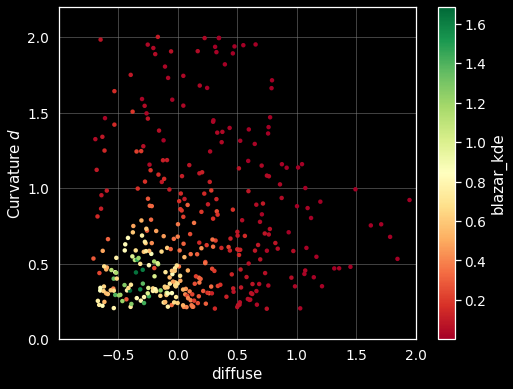

The colors correspond to the KDE determination for the 168 actual blazars which survived the
initial selection.

In [3]:
def d_vs_diffuse(df, which='bcu', kde='blazar'):
    

    fig, ax = plt.subplots(figsize=(8,6))
    data = df.query(f'subset=="{which}"')
    
    assert len(data)>0, f'No data selected with {which}'
    data_kw = dict(data=data,
                  s=20, edgecolor='none',c=data[kde+'_kde'], cmap='RdYlGn',# color='maroon', 
                  label=which) 
    ax.set( ylim=(0.,2.2),
           yticks=np.arange(0.,2.1,0.5), ylabel='Curvature ${d}$' )
    ax.set(xlim=(-1,2.), xticks=np.arange(-0.5,2.1,0.5),  xlabel='diffuse')
    scat = ax.scatter( x='diffuse', y='d',       **data_kw)
    cb =plt.colorbar(scat)
    cb.set_label(kde+'_kde')
    return fig
which='bcu'
show(f"""## Look at $d$ vs diffuse for {which}
Blazars with a known type are isotropic, and have small curvatures.
The former corresponds to small values for the diffuse parameter. The bcu's on the other hand,
populate much more of this space, as is seen below:
""")
show_fig(d_vs_diffuse, dfc, which)
show(f"""The colors correspond to the KDE determination for the {sum(dfc.target=='blazar')} actual blazars which survived the
initial selection.""")
# show_fig(d_vs_diffuse, dfc, 'blazar')

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7fe0e879ea40>
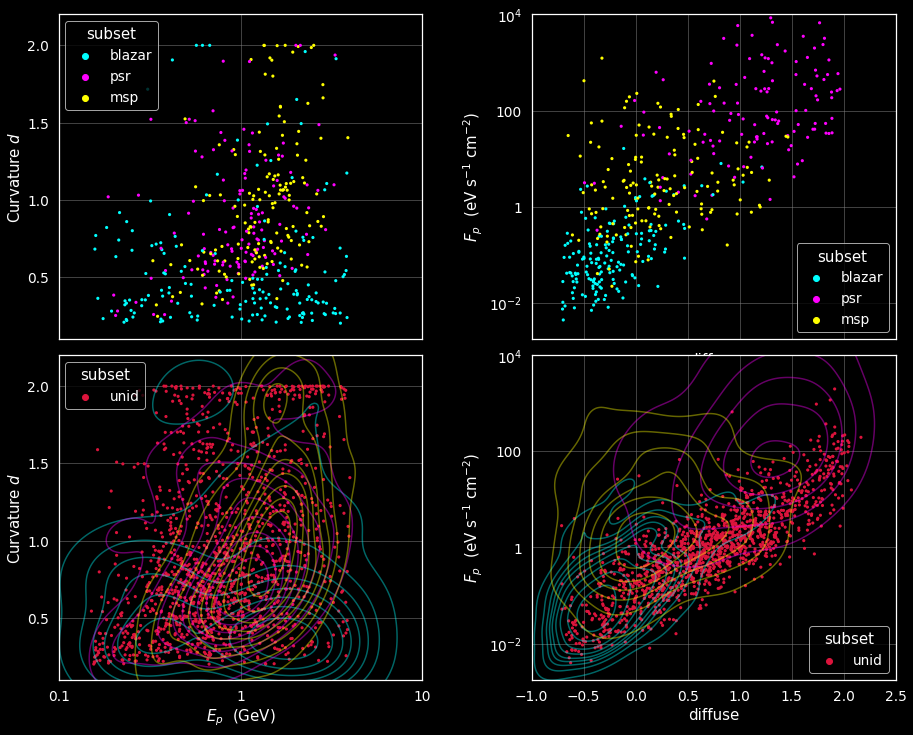

In [4]:
show_fig(plot_kde_density,self, dfc, hue_order=['unid'], palette=['crimson'])


NameError: name 'fig' is not defined

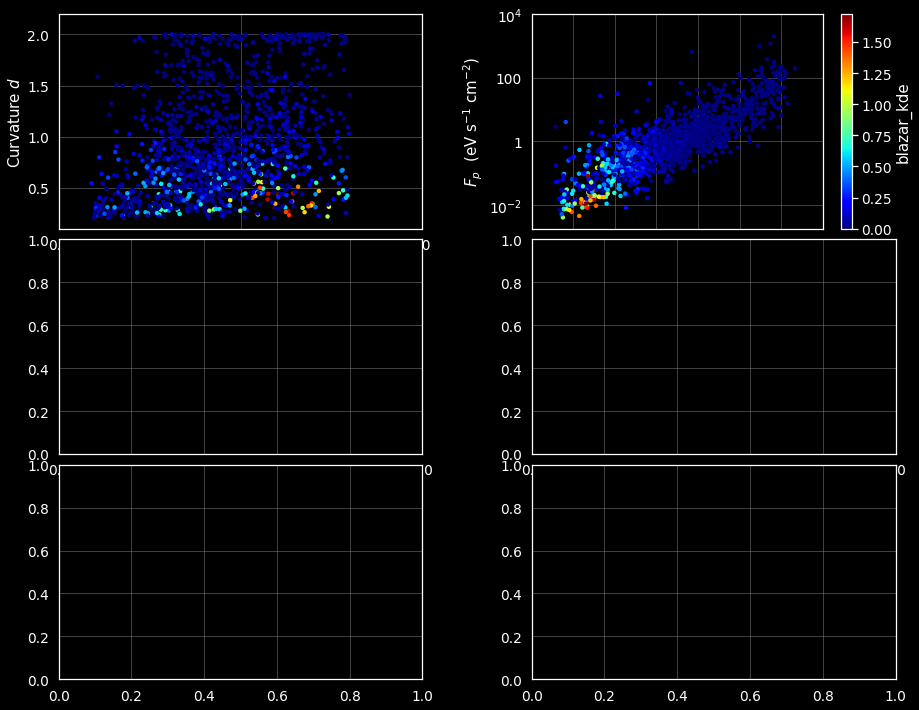

In [5]:
def data_scats(df, axx, which='unid', kde='blazar', cmap='jet'):
    ax1, ax2 = axx
    # fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1,  figsize=(12,5),  
    #                                 gridspec_kw=dict(wspace=0.3,hspace=0.05))
    data = df.query(f'subset=="{which}"')
    assert len(data)>0, f'No data selected with {which}'
    c =  data[kde+'_kde'] 
    data_kw = dict(data=data,
                  s=20, edgecolor='none', c=c, cmap=cmap,# color='maroon', 
                  label=which) 
    
    ax1.scatter( x='log_epeak', y='d',       **data_kw)
    scat = ax2.scatter( y='log_fpeak', x='diffuse', **data_kw);
    
    ax1.set(**epeak_kw(), xlim=(-1,1), ylim=(0.1,2.2),
           yticks=np.arange(0.5,2.1,0.5), ylabel='Curvature ${d}$' )
    ax2.set(ylim=(-2.75,4), **fpeak_kw('y'), xlim=(-1,2.5), xticks=np.arange(-0.5,2.1,0.5),
           xlabel='diffuse')
    # ax1.legend(); ax2.legend();
    cb= plt.colorbar(scat)
    cb.set_label(kde+'_kde')
    return fig 

def multi_scats(df, which, cmap):
    fig, axx = plt.subplots(ncols=2, nrows=3,  figsize=(15,12), sharex=False,  
                                    gridspec_kw=dict(wspace=0.3,hspace=0.05))
    data_scats(df, axx[0,:], which=which, kde='blazar')
    data_scats(df, axx[1,:], which=which,kde='psr')
    data_scats(df, axx[2,:], which=which,kde='msp')
    show(f"""### {which}""")
    return fig
    

for which in ['unid','bcu']:
    show_fig(multi_scats,dfc, which, 'jet')
    


In [ ]:
dfc['sum_kde'] = dfc.iloc[:,-3:].sum(axis=1)
show(f"""## Emphasize the outliers""")
which = 'unid'
# data = dfc.query(f'subset=="{which}"')['Ep d diffuse blazar_kde msp_kde psr_kde'.split()]
# data['sum_kde'] = data.iloc[:,-3:].sum(axis=1)
sns.histplot(dfc, x='sum_kde', bins=25, element='step');


In [ ]:
fig, axx = plt.subplots(ncols=2, figsize=(15,6))
data_scats(dfc, axx, which='unid', kde='sum', cmap='RdYlGn');

In [ ]:
def d_vs_diffuse(df, ax=None, which='bcu', kde='blazar', colorbar=True):
    

    fig, ax = plt.subplots(figsize=(8,6)) if ax is None else (ax.figure, ax)
    data = dfc.query(f'subset=="{which}"')
    
    assert len(data)>0, f'No data selected with {which}'
    data_kw = dict(data=data,
                  s=20, edgecolor='none',c=data[kde+'_kde'], cmap='RdYlGn',# color='maroon', 
                  label=which) 
    ax.set( ylim=(0.,2.2),
           yticks=np.arange(0.,2.1,0.5), ylabel='Curvature ${d}$' )
    ax.set(xlim=(-1,2.), xticks=np.arange(-0.5,2.1,0.5),  xlabel='diffuse',
          title=which)
    scat = ax.scatter( x='diffuse', y='d',       **data_kw)
    if colorbar:
        cb =plt.colorbar(scat)
        cb.set_label(kde+'_kde')
        
    return fig

show(f"""## Look at $d$ vs the diffuse correlation parameter """)
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5), sharey=True)
d_vs_diffuse( dfc, ax2, 'bcu', colorbar=True)
d_vs_diffuse( dfc, ax1, 'blazar', colorbar=False)
show(fig)

In [ ]:
is_blazar = self.df.association.apply(lambda x: x in 'bll fsrq'.split())
sum(is_blazar)

In [ ]:
dfc.loc[dfc.association=='bcu', 'group']= 'bcu'

In [ ]:
def fluxticks(x, ):
    ticks =  np.arange(0,2.1,1).astype(int)
    # energy = 900 if not hasattr(self, 'energy') else self.energy
    # unit = '' if not hasattr(self, 'unit') else f'({self.unit})'
    return {x+'ticks':ticks,
            x+'ticklabels' : [f'$10^{{{x}}}$' for x in ticks],
            x+'label': f'Diffuse energy flux'}# at {energy:.0f} MeV {unit}' }

def plot_limits(self, ax, n=50, **kwargs):
    self.check_hpm()

    def ecdf(x, n=None, xlim=None):
        """Return empirical cumulative distribution function
        Parameters
        - x input array
        - n -- number of x, y values to return for sampling mode
        - xlim -- x limits: use min,max of x if NOne
        returns:
            x, y
        """
        xs = np.sort(x)
        ys = np.arange(1, len(xs)+1)/float(len(xs))
        if n is None:
            return xs, ys
        # a,b = xlim if xlim is not None else x.min
        if xlim is None:  a,b = x.min(), x.max()
        else: a,b = xlim # xfull.min(), xfull.max()# if xlim is not None else xlim
        xrange = np.arange(a, b, (b-a)/n);
        idx = np.searchsorted(xs[:-1], xrange); 
        yrange = ys[idx]
        return xrange, yrange
    
    dfm= self.diffuse_hpm.map
    x1, y1 = ecdf(dfm, n, )
    dfmx= self.diffuse_hpm.map[self.ridge_mask]
    x2, y2 = ecdf(dfmx, n, xlim=(dfm.min(),dfm.max()))   
    
    kw = dict(color='0.5', alpha=0.6)
    kw.update(kwargs)
    ax.fill_between(x1, y1, y2, **kw );
    
def plot_diffuse_flux(self,   figsize=(8,8),  df=None, unid=False,  **kwargs):
    """Distributions of diffuse energy flux background values for the source types shown.
    Upper plot: histogram with overlaid KDE curves. Lower plot: corresponding cumulative empirical distribution functions.
    The gray area shows the range between an isotropic distribution and a uniform sampling of the Galactic ridge.
    """
    data = getattr(self, 'df', None) if df is None else df 
    
    if unid:
        hkw = dict(hue='source_type',
                hue_order = ['unid-'+ name for name in self.target_names],
                palette=self.palette)    
    else:
        hkw = self.hue_kw.copy()
        hkw.pop('edgecolor', '')
        hkw.update(kwargs)
    x='diffuse'

    fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=figsize, sharex=True,
                                gridspec_kw=dict(hspace=0.1))

    sns.histplot(data, ax=ax1, bins=25, kde=True, element='step', x=x,  **hkw, )
    # update_legend(ax1, data, hkw['hue'], fontsize=12)
    ax1.set(**fluxticks('x') )
    
    sns.ecdfplot(data, ax=ax2, x=x, legend=False,  **hkw)
    self.plot_limits( ax2, color='0.3')
    ax2.set(**fluxticks('x') )
    return fig
plot_diffuse_flux(self, df=dfc)

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=figsize, sharex=True,
                            gridspec_kw=dict(hspace=0.1))
data=dfc
hkw = self.hue_kw.copy()
hkw.update(hue=
sns.histplot(data, ax=ax1, bins=25, kde=True, element='step', x=x,  **hkw, )
# update_legend(ax1, data, hkw['hue'], fontsize=12)
ax1.set(**self.fluxticks('x') )

sns.ecdfplot(data, ax=ax2, x=x, legend=False,  **hkw)
self.plot_limits( ax2, color='0.3')
ax2.set(**self.fluxticks('x') )

In [ ]:
self.hue_kw

In [ ]:
t = dfc.association=='bcu'
show(sum(t))
dfc.group

dfc.groupby('association').size()

In [ ]:
dfc.loc[dfc.association=='bcu', 'group']= 'bcu'

In [ ]:
from pylib.diffuse import Diffuse
diff = Diffuse()

In [ ]:
diff.hue_kw=dict(hue='group', hue_order='bcu blazar psr msp'.split())

In [ ]:
plt.style.use('dark_background') #s
plt.rcParams['grid.color']='0.5'

diff.plot_diffuse_flux(df=dfc);

In [ ]:
sns.histplot(data=dfc, x=np.abs(np.sin(np.radians(dfc.glat) )),
            element='step', bins=np.arange(0,1,0.05),
            hue='group', hue_order='blazar psr bcu'.split());

In [ ]:
3.25/1.6